In [6]:
import pandas as pd 
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from numpy import interp
from sklearn import preprocessing,manifold
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold

In [8]:
data = pd.read_csv("mfccToyExpALL.csv",header=None)
data = pd.DataFrame(data).to_numpy()
data.shape

(1000, 80)

In [9]:
data = data[~np.isnan(data).any(axis=1)]
data.shape

target = data[:,-2]
X = data[:,:-2]
order = data[:,-1]
order = order.reshape(order.shape[0],1)
X_norm = (X-X.min(axis=0))/(X.max(axis=0)-X.min(axis=0))
print(data.shape,X.shape,order.shape)
X_complete = np.concatenate((X_norm, order), axis=1)

(1000, 80) (1000, 78) (1000, 1)


In [10]:
def train_test_split_genres(data,target,percentage):
    div = int(data.shape[0]/3)
    X_train, X_test, y_train,y_test = np.empty((0,data.shape[1])),np.empty((0,data.shape[1])),np.empty((0,1)),np.empty((0,1))
    for i in range(3):
        X_train_aux, X_test_aux, y_train_aux, y_test_aux = train_test_split(data[i*div:(i*div)+div,:], target[i*div:(i*div)+div], test_size=percentage)
        X_train, X_test,y_train,y_test=np.append(X_train,X_train_aux,axis=0), np.append(X_test,X_test_aux,axis=0),np.append(y_train,y_train_aux),np.append(y_test,y_test_aux)
    return X_train,X_test,y_train,y_test

In [66]:
def classifier_selection(X_train,X_test,y_train,y_test):
    Results = np.empty((5,3), dtype='object')

    # Logistic Regression
    logistic = LogisticRegression(max_iter = 100000)
    logistic.fit(X_train,y_train)
    accuracy_train = np.sum(logistic.predict(X_train) == y_train)/len(y_train)
    Results[0,0]=str((1-accuracy_train)*100)+"%"
    accuracy_test = np.sum(logistic.predict(X_test) == y_test)/len(y_test)
    Results[0,1]=str((1-accuracy_test)*100)+"%"

    classifier,best_accuracy_train,best_accuracy_test = logistic, accuracy_train, accuracy_test #Initializing values
    print("logistic")

    # Support vector machine linear kernel
    parameters = {'C':[0.1,0.01,1,10]}
    linear_kernel_svm_clf = svm.SVC(kernel = "linear")
    clf = GridSearchCV(linear_kernel_svm_clf, parameters)
    clf.fit(X_train, y_train)
    Results[1,2]=clf.best_params_
    accuracy_train = np.sum(clf.predict(X_train) == y_train)/len(y_train)
    Results[1,0]=str((1-accuracy_train)*100)+"%"
    accuracy_test = np.sum(clf.predict(X_test) == y_test)/len(y_test)
    if(best_accuracy_train < accuracy_train or (best_accuracy_train == accuracy_train and best_accuracy_test < accuracy_test)):
        classifier, best_accuracy_train, best_accuracy_testn = clf, accuracy_train, accuracy_test
    Results[1,1]=str((1-accuracy_test)*100)+"%"
    print("svm 1")

    # Support vector machine polynomial kernel
    parameters = {'degree':[2,3,4,5,6,7,8,9,10], 'C':[0.1,0.01,1,10]}
    poly_kernel_svm_clf = svm.SVC(kernel = "poly")
    clf = GridSearchCV(poly_kernel_svm_clf, parameters)
    clf.fit(X_train, y_train)
    Results[2,2]=clf.best_params_
    accuracy_train = np.sum(clf.predict(X_train) == y_train)/len(y_train)
    Results[2,0]=str((1-accuracy_train)*100)+"%"
    accuracy_test = np.sum(clf.predict(X_test) == y_test)/len(y_test)
    if(best_accuracy_train < accuracy_train or (best_accuracy_train == accuracy_train and best_accuracy_test < accuracy_test)):
        classifier, best_accuracy_train, best_accuracy_testn = clf, accuracy_train, accuracy_test
    Results[2,1]=str((1-accuracy_test)*100)+"%"
    print("svm 2")

    # Support vector machine rbf kernel
    parameters = {'gamma':[0.001,0.01,0.1,1,10], 'C':[0.1,0.01,1,10]}
    rbf_kernel_svm_clf = svm.SVC(kernel = "rbf",gamma=30,C=10)
    clf = GridSearchCV(rbf_kernel_svm_clf, parameters)
    clf.fit(X_train, y_train)
    Results[3,2]=clf.best_params_
    accuracy_train = np.sum(clf.predict(X_train) == y_train)/len(y_train)
    Results[3,0]=str((1-accuracy_train)*100)+"%"
    accuracy_test = np.sum(clf.predict(X_test) == y_test)/len(y_test)
    if(best_accuracy_train < accuracy_train or (best_accuracy_train == accuracy_train and best_accuracy_test < accuracy_test)):
        classifier, best_accuracy_train, best_accuracy_testn = clf, accuracy_train, accuracy_test
    Results[3,1]=str((1-accuracy_test)*100)+"%"
    print("svm 3")

    # Multilayer Perceptron
    parameters = {'activation':['relu','tanh','logistic'], 'learning_rate_init':[0.0002,0.0001,0.0009,0.005], 'solver': ['sgd', 'adam'], 'learning_rate':['constant','adaptive'],'hidden_layer_sizes':[(100,100,100,100,100)],'max_iter':[400]}
    nn = MLPClassifier(hidden_layer_sizes=(100,100,100,100,100),max_iter=400)
    clf = GridSearchCV(nn, parameters)
    clf.fit(X_train,y_train)
    Results[4,2]=clf.best_params_
    accuracy_train = np.sum(clf.predict(X_train) == y_train)/len(y_train)
    Results[4,0]=str((1-accuracy_train)*100)+"%"
    accuracy_test = np.sum(clf.predict(X_test) == y_test)/len(y_test)
    if(best_accuracy_train < accuracy_train or (best_accuracy_train == accuracy_train and best_accuracy_test < accuracy_test)):
        classifier, best_accuracy_train, best_accuracy_testn = clf, accuracy_train, accuracy_test
    Results[4,1]=str((1-accuracy_test)*100)+"%"
    print("MLP")


    Results_df = pd.DataFrame(data=Results, index=["Logistic Regression","SVM linear kernel","SVM polynomial kernel","SVM rbf kernel","Multilayer Perceptorn"], columns=["Error train","Error test","Parameters"])
    print(Results_df)

    return classifier, Results

In [12]:
def split_embedding(Xe,check_test,check_train):
    Xe_train, Xe_test,Xe_val = np.empty((0,int(Xe.shape[1]))),np.empty((0,int(Xe.shape[1]))),np.empty((0,int(Xe.shape[1])))
    for i in range(int(Xe.shape[0])):
        if((i in check_test)==True):
            Xe_test = np.append(Xe_test,Xe[i,:].reshape(1,-1),axis=0)
        elif ( (i in check_train)==True):
            Xe_train = np.append(Xe_train,Xe[i,:].reshape(1,-1),axis=0)
        
    
    return Xe_train, Xe_test

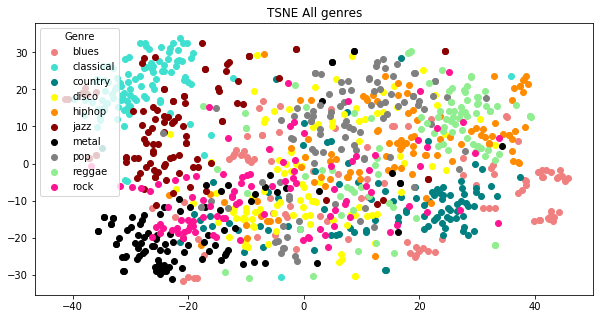

In [15]:
Xe= manifold.TSNE( metric='euclidean', method='barnes_hut').fit_transform(X_norm)
fig,ax=plt.subplots()
ax.scatter(Xe[target==1,0],Xe[target==1,1],c="lightcoral",label="blues")
ax.scatter(Xe[target==2,0],Xe[target==2,1],c="turquoise",label="classical")
ax.scatter(Xe[target==3,0],Xe[target==3,1],c="teal",label="country")
ax.scatter(Xe[target==4,0],Xe[target==4,1],c="yellow",label="disco")
ax.scatter(Xe[target==5,0],Xe[target==5,1],c="darkorange",label="hiphop")
ax.scatter(Xe[target==6,0],Xe[target==6,1],c="darkred",label="jazz")
ax.scatter(Xe[target==7,0],Xe[target==7,1],c="black",label="metal")
ax.scatter(Xe[target==8,0],Xe[target==8,1],c="grey",label="pop")
ax.scatter(Xe[target==9,0],Xe[target==9,1],c="lightgreen",label="reggae")
ax.scatter(Xe[target==10,0],Xe[target==10,1],c="deeppink",label="rock")
plt.legend(loc='upper left',title="Genre")
fig.set_size_inches(10, 5, forward=True)
plt.title('TSNE All genres')
plt.show()

X_train, X_test, y_train, y_test = train_test_split_genres(X_complete, target,0.2)
check_test = X_test[:,-1]
check_train = X_train[:,-1]
X_train,X_test= X_train[:,:-1],X_test[:,:-1]
Xe_train,Xe_test= split_embedding(Xe,check_test,check_train)

# Hierarhichal Classification


In [69]:
def plotgenres(Xe,target,pred,title):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.title.set_text('Real')
    ax2.title.set_text('Predicted')
    ax1.scatter(Xe[target==0,0],Xe[target==0,1],c="lightcoral",label="others")
    ax1.scatter(Xe[target==1,0],Xe[target==1,1],c="black",label="classical or jazz")
    
    ax2.scatter(Xe[pred==0,0],Xe[pred==0,1],c="lightcoral",label="others")
    ax2.scatter(Xe[pred==1,0],Xe[pred==1,1],c="black",label="classical or jazz")
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center')
    fig.set_size_inches(10, 5, forward=True)
    fig.suptitle(title)
    plt.show()

(800, 78) (1000, 78)
(560, 78) (240, 78)
(200, 78) (1000, 78)
(140, 78) (60, 78)
logistic
svm 1
svm 2
svm 3
MLP
                                Error train           Error test  \
Logistic Regression     2.1428571428571463%  3.0000000000000027%   
SVM linear kernel         1.28571428571429%  3.0000000000000027%   
SVM polynomial kernel  0.28571428571428914%  3.6666666666666625%   
SVM rbf kernel          0.8571428571428563%  3.0000000000000027%   
Multilayer Perceptorn                  0.0%   4.333333333333334%   

                                                              Parameters  
Logistic Regression                                                 None  
SVM linear kernel                                               {'C': 1}  
SVM polynomial kernel                           {'C': 0.01, 'degree': 5}  
SVM rbf kernel                                   {'C': 10, 'gamma': 0.1}  
Multilayer Perceptorn  {'activation': 'relu', 'hidden_layer_sizes': (...  


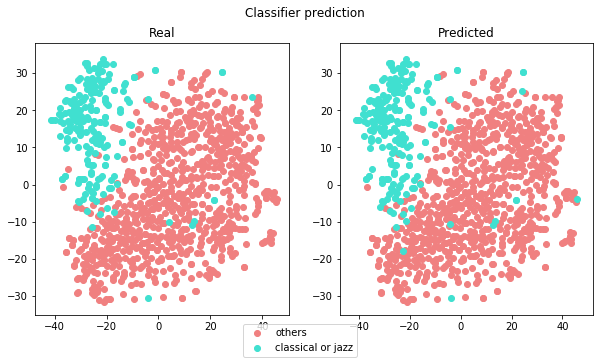

In [68]:
target2 = np.zeros((target.shape))
target2 = np.where(target==2, 1, target2) 
target2 = np.where(target==6, 1, target2) 
X_train,X_test,y_train,y_test =np.empty((0,X_norm.shape[1])),np.empty((0,X_norm.shape[1])),np.empty((0,1)),np.empty((0,1))
for i in np.unique(target2):
    data_aux = X_norm[np.where(target2 == i)]
    target_aux = target2[np.where(target2== i)]
    print(data_aux.shape,X_norm.shape)
    X_train_aux, X_test_aux, y_train_aux, y_test_aux = train_test_split(data_aux,target_aux, test_size=0.3)
    print(X_train_aux.shape,X_test_aux.shape)
    X_train, X_test,y_train,y_test=np.append(X_train,X_train_aux,axis=0), np.append(X_test,X_test_aux,axis=0),np.append(y_train,y_train_aux),np.append(y_test,y_test_aux)
classifier, Results = classifier_selection(X_train,X_test,y_train,y_test)

pred = classifier.predict(X_norm)
plotgenres(Xe,target2,pred,"Classifier prediction")

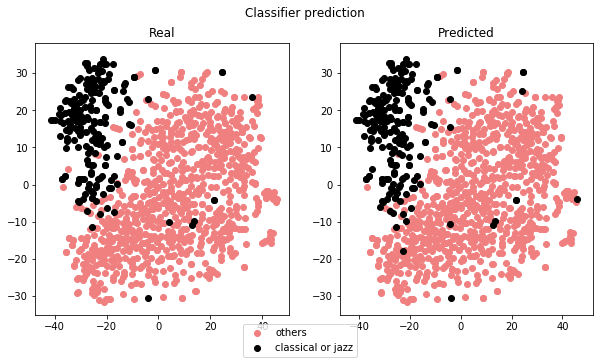

,Error train,Error test,Parameters
Logistic Regression,2.1428571428571463%,3.0000000000000027%,None
SVM linear kernel,1.28571428571429%,3.0000000000000027%,{'C': 1}
SVM polynomial kernel,0.28571428571428914%,3.6666666666666625%,"{'C': 0.01, 'degree': 5}"
SVM rbf kernel,0.8571428571428563%,3.0000000000000027%,"{'C': 10, 'gamma': 0.1}"
Multilayer Perceptorn,0.0%,4.333333333333334%,"{'activation': 'relu', 'hidden_layer_sizes': (..."


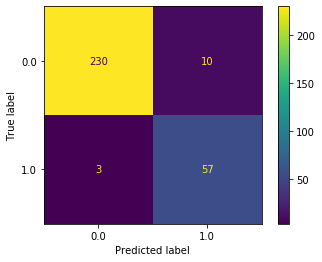

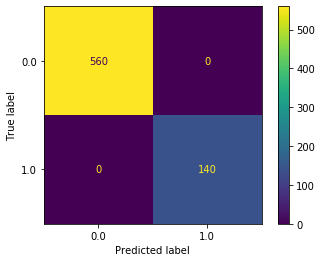

In [71]:
pred = classifier.predict(X_norm)
plotgenres(Xe,target2,pred,"Classifier prediction")
plot_confusion_matrix(classifier,X_test,y_test)
plot_confusion_matrix(classifier,X_train,y_train)
pd.DataFrame(data=Results, index=["Logistic Regression","SVM linear kernel","SVM polynomial kernel","SVM rbf kernel","Multilayer Perceptorn"], columns=["Error train","Error test","Parameters"])

## Jazz/Classical Classification

In [72]:
def plotgenres2(Xe,target,pred,title):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.title.set_text('Real')
    ax2.title.set_text('Predicted')
    ax1.scatter(Xe[target==2,0],Xe[target==2,1],c="turquoise",label="classical")
    ax1.scatter(Xe[target==6,0],Xe[target==6,1],c="darkred",label="jazz")    
    
    ax2.scatter(Xe[pred==2,0],Xe[pred==2,1],c="turquoise",label="classical")
    ax2.scatter(Xe[pred==6,0],Xe[pred==6,1],c="darkred",label="jazz")
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center')
    fig.set_size_inches(10, 5, forward=True)
    fig.suptitle(title)
    plt.show()

(200, 2) (200,)


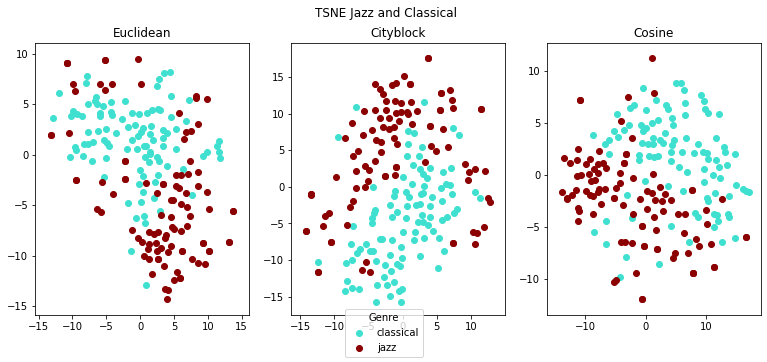

In [110]:
data2 = X_complete[np.where(target == 2)]
data2 = np.append(data2,X_complete[np.where(target == 6)],axis=0)
target2 = target[np.where(target ==2)]
target2 = np.append(target2,target[np.where(target == 6)],axis=0)
Xe= manifold.TSNE( metric='cityblock', method='barnes_hut').fit_transform(data2[:,:-1])
print(Xe.shape,target2.shape)
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
ax1.title.set_text('Euclidean')
ax2.title.set_text('Cityblock')
ax3.title.set_text('Cosine')

Xe= manifold.TSNE( metric='euclidean', method='barnes_hut').fit_transform(data2[:,:-1])
ax1.scatter(Xe[target2==2,0],Xe[target2==2,1],c="turquoise",label="classical")
ax1.scatter(Xe[target2==6,0],Xe[target2==6,1],c="darkred",label="jazz")
Xe= manifold.TSNE( metric='cityblock', method='barnes_hut').fit_transform(data2[:,:-1])
ax2.scatter(Xe[target2==2,0],Xe[target2==2,1],c="turquoise",label="classical")
ax2.scatter(Xe[target2==6,0],Xe[target2==6,1],c="darkred",label="jazz")
Xe= manifold.TSNE( metric='cosine', method='barnes_hut').fit_transform(data2[:,:-1])
ax3.scatter(Xe[target2==2,0],Xe[target2==2,1],c="turquoise",label="classical")
ax3.scatter(Xe[target2==6,0],Xe[target2==6,1],c="darkred",label="jazz")
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',title='Genre')
fig.set_size_inches(13, 5, forward=True)
fig.suptitle("TSNE Jazz and Classical")
plt.show()

In [88]:
X_train,X_test,y_train,y_test =np.empty((0,data2.shape[1])),np.empty((0,data2.shape[1])),np.empty((0,1)),np.empty((0,1))
for i in np.unique(target2):
    data_aux = data2[np.where(target2 == i)]
    target_aux = target2[np.where(target2== i)]
    print(target_aux.shape,data2.shape)
    X_train_aux, X_test_aux, y_train_aux, y_test_aux = train_test_split(data_aux,target_aux, test_size=0.3)
    print(X_train_aux.shape,X_test_aux.shape)
    X_train, X_test,y_train,y_test=np.append(X_train,X_train_aux,axis=0), np.append(X_test,X_test_aux,axis=0),np.append(y_train,y_train_aux),np.append(y_test,y_test_aux)

check_test, check_train = X_test[:,-1],X_train[:,-1]
X_train,X_test= X_train[:,:-1],X_test[:,:-1]
classifier, Results = classifier_selection(X_train,X_test,y_train,y_test)


(100,) (200, 79)
(70, 79) (30, 79)
(100,) (200, 79)
(70, 79) (30, 79)
logistic
svm 1
svm 2
svm 3
MLP
                               Error train          Error test  \
Logistic Regression     2.857142857142858%  11.66666666666667%   
SVM linear kernel        3.57142857142857%  8.333333333333337%   
SVM polynomial kernel   2.857142857142858%  6.666666666666665%   
SVM rbf kernel         0.7142857142857117%  6.666666666666665%   
Multilayer Perceptorn  2.1428571428571463%  9.999999999999998%   

                                                              Parameters  
Logistic Regression                                                 None  
SVM linear kernel                                               {'C': 1}  
SVM polynomial kernel                            {'C': 0.1, 'degree': 3}  
SVM rbf kernel                                   {'C': 10, 'gamma': 0.1}  
Multilayer Perceptorn  {'activation': 'tanh', 'hidden_layer_sizes': (...  


IndexError: boolean index did not match indexed array along dimension 0; dimension is 200 but corresponding boolean dimension is 1000

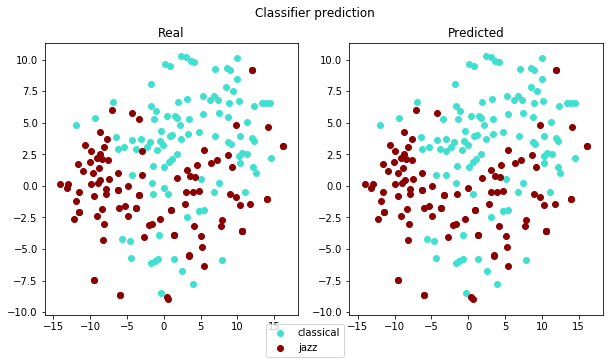

,Error train,Error test,Parameters
Logistic Regression,2.857142857142858%,11.66666666666667%,None
SVM linear kernel,3.57142857142857%,8.333333333333337%,{'C': 1}
SVM polynomial kernel,2.857142857142858%,6.666666666666665%,"{'C': 0.1, 'degree': 3}"
SVM rbf kernel,0.7142857142857117%,6.666666666666665%,"{'C': 10, 'gamma': 0.1}"
Multilayer Perceptorn,2.1428571428571463%,9.999999999999998%,"{'activation': 'tanh', 'hidden_layer_sizes': (..."


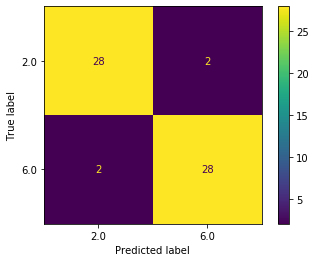

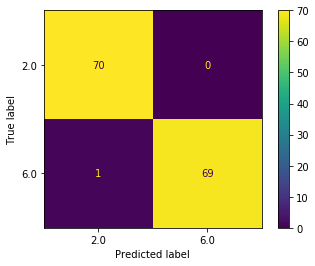

In [90]:
pred = classifier.predict(data2[:,:-1])
plotgenres2(Xe,target2,pred,"Classifier prediction")
plot_confusion_matrix(classifier,X_test,y_test)
plot_confusion_matrix(classifier,X_train,y_train)
pd.DataFrame(data=Results, index=["Logistic Regression","SVM linear kernel","SVM polynomial kernel","SVM rbf kernel","Multilayer Perceptorn"], columns=["Error train","Error test","Parameters"])

# Other genres (blues, country, disco, hiphop, metal, pop, rock, reggae )

In [91]:
def plotgenres3(Xe,target,pred,title):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.title.set_text('Real')
    ax2.title.set_text('Predicted')
    ax1.scatter(Xe[target==1,0],Xe[target==1,1],c="lightcoral",label="blues")
    ax1.scatter(Xe[target==3,0],Xe[target==3,1],c="teal",label="country")
    ax1.scatter(Xe[target==4,0],Xe[target==4,1],c="yellow",label="disco")
    ax1.scatter(Xe[target==5,0],Xe[target==5,1],c="darkorange",label="hiphop")
    ax1.scatter(Xe[target==7,0],Xe[target==7,1],c="black",label="metal")
    ax1.scatter(Xe[target==8,0],Xe[target==8,1],c="grey",label="pop")
    ax1.scatter(Xe[target==9,0],Xe[target==9,1],c="lightgreen",label="reggae")
    ax1.scatter(Xe[target==10,0],Xe[target==10,1],c="deeppink",label="rock")
    
    ax2.scatter(Xe[pred==1,0],Xe[pred==1,1],c="lightcoral",label="blues")
    ax2.scatter(Xe[pred==3,0],Xe[pred==3,1],c="teal",label="country")
    ax2.scatter(Xe[pred==4,0],Xe[pred==4,1],c="yellow",label="disco")
    ax2.scatter(Xe[pred==5,0],Xe[pred==5,1],c="darkorange",label="hiphop")
    ax2.scatter(Xe[pred==7,0],Xe[pred==7,1],c="black",label="metal")
    ax2.scatter(Xe[pred==8,0],Xe[pred==8,1],c="grey",label="pop")
    ax2.scatter(Xe[pred==9,0],Xe[pred==9,1],c="lightgreen",label="reggae")
    ax2.scatter(Xe[pred==10,0],Xe[pred==10,1],c="deeppink",label="rock")
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center')
    fig.set_size_inches(10, 5, forward=True)
    fig.suptitle(title)
    plt.show()

(200, 2) (800,)


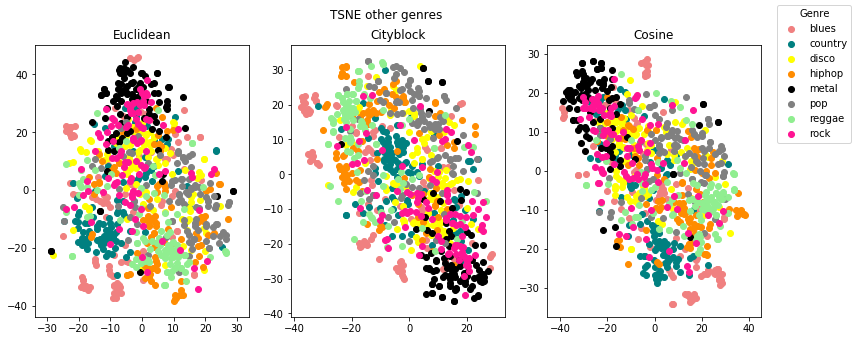

In [111]:
data3, target3 = np.empty((0,X_complete.shape[1])),np.empty(0)
for i in [1,3,4,5,7,8,9,10]:
    data3 = np.append(data3,X_complete[np.where(target == i)],axis=0)
    target3 = np.append(target3,target[np.where(target == i)],axis=0)
print(Xe.shape,target3.shape)
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
ax1.title.set_text('Euclidean')
ax2.title.set_text('Cityblock')
ax3.title.set_text('Cosine')

Xe= manifold.TSNE( metric='euclidean', method='barnes_hut').fit_transform(data3[:,:-1])
ax1.scatter(Xe[target3==1,0],Xe[target3==1,1],c="lightcoral",label="blues")
ax1.scatter(Xe[target3==3,0],Xe[target3==3,1],c="teal",label="country")
ax1.scatter(Xe[target3==4,0],Xe[target3==4,1],c="yellow",label="disco")
ax1.scatter(Xe[target3==5,0],Xe[target3==5,1],c="darkorange",label="hiphop")
ax1.scatter(Xe[target3==7,0],Xe[target3==7,1],c="black",label="metal")
ax1.scatter(Xe[target3==8,0],Xe[target3==8,1],c="grey",label="pop")
ax1.scatter(Xe[target3==9,0],Xe[target3==9,1],c="lightgreen",label="reggae")
ax1.scatter(Xe[target3==10,0],Xe[target3==10,1],c="deeppink",label="rock")
Xe= manifold.TSNE( metric='cityblock', method='barnes_hut').fit_transform(data3[:,:-1])
ax2.scatter(Xe[target3==1,0],Xe[target3==1,1],c="lightcoral",label="blues")
ax2.scatter(Xe[target3==3,0],Xe[target3==3,1],c="teal",label="country")
ax2.scatter(Xe[target3==4,0],Xe[target3==4,1],c="yellow",label="disco")
ax2.scatter(Xe[target3==5,0],Xe[target3==5,1],c="darkorange",label="hiphop")
ax2.scatter(Xe[target3==7,0],Xe[target3==7,1],c="black",label="metal")
ax2.scatter(Xe[target3==8,0],Xe[target3==8,1],c="grey",label="pop")
ax2.scatter(Xe[target3==9,0],Xe[target3==9,1],c="lightgreen",label="reggae")
ax2.scatter(Xe[target3==10,0],Xe[target3==10,1],c="deeppink",label="rock")
Xe= manifold.TSNE( metric='cosine', method='barnes_hut').fit_transform(data3[:,:-1])
ax3.scatter(Xe[target3==1,0],Xe[target3==1,1],c="lightcoral",label="blues")
ax3.scatter(Xe[target3==3,0],Xe[target3==3,1],c="teal",label="country")
ax3.scatter(Xe[target3==4,0],Xe[target3==4,1],c="yellow",label="disco")
ax3.scatter(Xe[target3==5,0],Xe[target3==5,1],c="darkorange",label="hiphop")
ax3.scatter(Xe[target3==7,0],Xe[target3==7,1],c="black",label="metal")
ax3.scatter(Xe[target3==8,0],Xe[target3==8,1],c="grey",label="pop")
ax3.scatter(Xe[target3==9,0],Xe[target3==9,1],c="lightgreen",label="reggae")
ax3.scatter(Xe[target3==10,0],Xe[target3==10,1],c="deeppink",label="rock")

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right',title='Genre')
fig.set_size_inches(13, 5, forward=True)
fig.suptitle("TSNE other genres")
plt.show()